In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold

In [5]:
def score_one_bw(X, bw, kernel='gaussian'):
    """Returns the log probability of the kernel 
    density estimate on X """
    kde = KernelDensity(bw, kernel=kernel).fit(X)
    logprob = kde.score(X)
    return logprob

In [6]:
def score_all_bw(x, kernel):
    """Returns the log probabilities of X over all 
    bandwidths"""
    
    bws = np.linspace(1,7, 100)
    scores = np.zeros(len(bws))
    X = x[:, np.newaxis]
    
    for i, bw in enumerate(bws):
        scores[i] = score_one_bw(X = X, bw = bw)
    
    return bws, scores



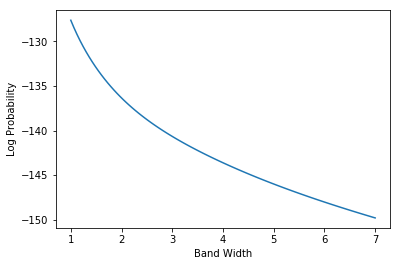

In [7]:
fname = '/home/esmee/Documents/DBDM/DDM2017-master/Datasets/joint-bh-mass-table.csv'
t = Table().read(fname)

bws, scores = score_all_bw(t['MBH'], 'gaussian')

plt.plot(bws, scores)
plt.xlabel("Band Width")
plt.ylabel("Log Probability")
plt.show()

b) Use cross-validation to find the optimal bandwidth

In [8]:
from sklearn.model_selection import KFold


In [9]:
def bh_kfold(x, bws, k_folds=10, kernel="gaussian"):
    
    #set variables
    N = len(x)
    N_bw = len(bws)
    scores = np.zeros(N_bw)
    
    #data in the form of n_samples x n_features
    X = x[:,np.newaxis]
    
    for i, bw in enumerate(bws):
        
        #Set up kfold validation
        kf = KFold(k_folds)
        
        #Reset log probability
        lnP = 0.0
        
        #Go through all k folds
        for train, test in kf.split(X):
            Xtrain = X[train,:]
            Xtest = X[test, :]
            
            #Create Kernel Density Estimate fitted on Xtrain
            kde = KernelDensity(bw, kernel='gaussian').fit(Xtrain)
            
            #Get the log prob for the test data
            logprob = kde.score(Xtest)
            
            #Add log probability of all folds for a certain bw 
            lnP += logprob
        scores[i] = lnP
    return scores  

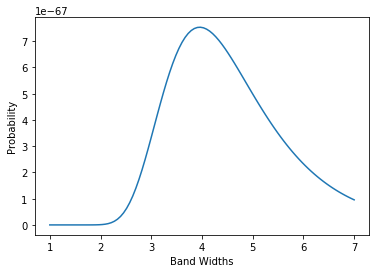

Beste fit with bandwidth 3.9696969697


In [10]:
lnProb = bh_kfold(t["MBH"], bws = np.linspace(1,7, 100))
P = np.exp(lnProb)

plt.plot(np.linspace(1,7, 100), P)
plt.xlabel("Band Widths")
plt.ylabel("Probability")
plt.show()

print "Beste fit with bandwidth {}".format(bws[np.argmax(P)])

## Problem 2
a) Use the pulsar mass catalogue to estimate the likelihood of finding a neutron star with M > 1.8 M ⊙ .


In [11]:
#Read in the datafile
fname = "/home/esmee/Documents/DBDM/DDM2017-master/Datasets/pulsar_masses.vot"
t = Table().read(fname)

mass = t["Mass"]
mrange = [min(mass), max(mass)]
print mrange

[0.95099998, 2.6340001]


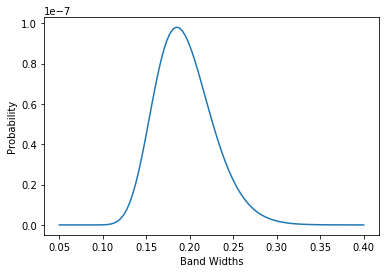

Beste fit with bandwidth 0.184343434343
Probability P(x > 1.8 Msun) = 0.174406744931


In [12]:
#The kernel density estimate is an estimate of P(M_neutronstar) so we use the previous exercise
bws_ns = np.linspace(0.05, 0.4, 100)
lnProb = bh_kfold(mass, bws = bws_ns)
P = np.exp(lnProb)

plt.plot(bws_ns, P)
plt.xlabel("Band Widths")
plt.ylabel("Probability")
plt.show()

print "Beste fit with bandwidth {}".format(bws_ns[np.argmax(P)])

#To get the probability P(x > 1.8) we need to integrate over the kernel density estimate
bw_ns = bws_ns[np.argmax(P)]
kde = KernelDensity(bw_ns, kernel="gaussian").fit(mass[:,np.newaxis])

def P_distribution(kde, xmin, xmax=None):
    """Returns the normalised probability P(xmin < X < xmax)"""
    
    if xmax == None:
        xmax = 5.0
    
    #Make the whole grid
    grid = np.linspace(0.0, 5.0, 1000)
    lnP_norm = kde.score_samples(grid[:, np.newaxis])
    P_norm = np.exp(lnP_norm)
    
    #The normalisation factor
    norm = np.trapz(P_norm, grid)
    
    #For the subspace xmin < X < xmax
    xgrid = np.linspace(xmin, xmax, 1000)
    lnP_sub = kde.score_samples(xgrid[:, np.newaxis])
    P_sub = np.exp(lnP_sub)
    P = np.trapz(P_sub, xgrid)
    
    return P/norm

print "Probability P(x > 1.8 Msun) = {}".format(P_distribution(kde = kde, xmin = 1.8))

b) Actually the mass estimates are ranges, and the masses were M
1 ∈ [1.36,2.26] and
M 2 ∈ [0.86,1.36] . What are the likelihoods of those mass ranges and the likelihood of the binary?

In [13]:
P1 = P_distribution(kde, xmin = 1.36, xmax = 2.26)
P2 = P_distribution(kde, xmin = 0.86, xmax = 1.36)

print "Probabilities of \n P(1.36 < x < 2.26 = {0:.3f} \n P(0.86 < x < 1.36) = {1:.3f})\n".format(P1, P2)
print "Probability on the binary \n P(binary) = {0:.3f}".format(P1 * P2)

Probabilities of 
 P(1.36 < x < 2.26 = 0.599 
 P(0.86 < x < 1.36) = 0.361)

Probability on the binary 
 P(binary) = 0.216


c) Simulate the next 5 detections of merging pulsars with LIGO+Virgo. What is your prediction for
the average mass neutron star they would detect?

In [21]:
s1 = kde.sample(5)
s2 = kde.sample(5)
detect = [(s1[i][0],s2[i][0]) for i in range(5)]
print "The next 5 detections \n {0} \nWith a mean of {1:.3f} Msun".format(detect, np.mean(detect))

The next 5 detections 
 [(1.7745890293159905, 1.3676990050914584), (1.5005343424475706, 1.3525097588285113), (1.1128225002307484, 1.7935011654719804), (1.846935101002622, 1.5362396956465894), (1.7021723561569853, 1.6922415584254502)] 
With a mean of 1.568 Msun


# Problem 3
The file Datasets/mysterious-peaks.pkl contains data drawn from a distribution with mul-
tiple peaks. How many peaks are there?


AIC: number of components = 9
BIC: number of components = 6


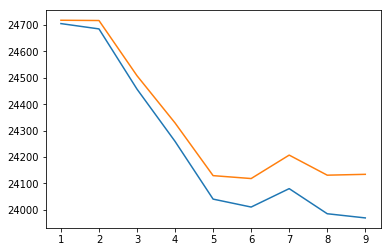

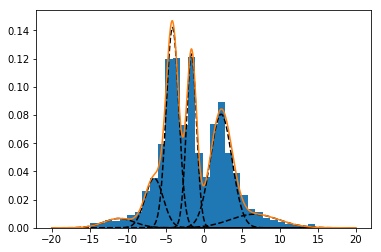

In [48]:
import cPickle 
from sklearn.mixture import GaussianMixture
#load the data
fname = "/home/esmee/Documents/DBDM/DDM2017-master/Datasets/mysterious-peaks.pkl"
f = open(fname, "r")
x = cPickle.load(f)

X = x[:,np.newaxis]
nPeaks = range(1,10)
models = [None for i in nPeaks]

#Make models with n peaks
for i, n in enumerate(nPeaks):
    models[i] = GaussianMixture(n_components = n).fit(X)

#Calculate the AIC and BIC number
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#Find the minimum value and the number of components
print "AIC: number of components = {0}".format(nPeaks[np.argmin(AIC)])
print "BIC: number of components = {0}".format(nPeaks[np.argmin(BIC)])

#Plot the AIC and BIC 
plt.plot(nPeaks, AIC)
plt.plot(nPeaks, BIC)
plt.show()

#Make the kernel density estimate of the best model
best_model = models[np.argmin(BIC)]
xgrid = np.linspace(-20, 20, 1000)[:,np.newaxis]
lnP = best_model.score_samples(xgrid)
P = np.exp(lnP)
#Get probabilities of all individual peaks
P_peak = best_model.predict_proba(xgrid)* P[:,np.newaxis]

plt.hist(X, 30, normed = True)
plt.plot(xgrid, P_peak, color = 'black', ls = '--')
plt.plot(xgrid, P)
plt.show()


# Problem 4
a) Compare the 'gaussian', 'tophat', 'exponential' and 'epanechnikov' kernels for the density infer-
ence - use a fixed smoothing parameter (for instance 5) - how does the appearance differ between
these different kernels.

In [4]:
from astroML.datasets import fetch_great_wall

X = fetch_great_wall()

In [19]:
# Produce KDE
kde_gaus = KernelDensity(5, kernel='gaussian').fit(X)
kde_th = KernelDensity(5, kernel='tophat').fit(X)
kde_exp = KernelDensity(5, kernel='exponential').fit(X)
kde_ep = KernelDensity(5, kernel='epanechnikov').fit(X)

In [24]:
# Create the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

xgrid = np.linspace(xmin, xmax, Nx)
ygrid = np.linspace(ymin, ymax, Ny)
mesh = np.meshgrid(xgrid, ygrid)

tmp = map(np.ravel, mesh)
Xgrid = np.vstack(tmp).T

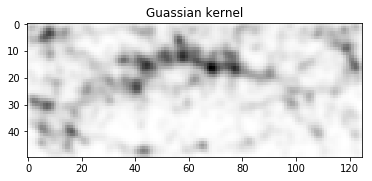

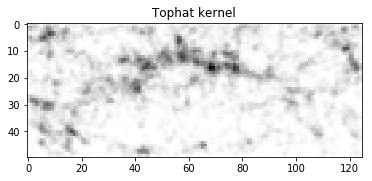

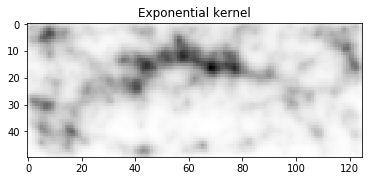

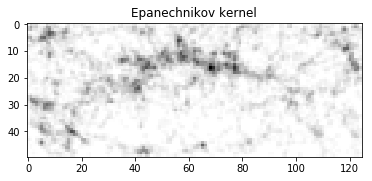

In [26]:
# Evaluate all KDE's on the grid

## Gaussian
log_dens = kde_gaus.score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens).reshape((Ny,Nx))
## Plot the density
plt.imshow(dens1.T, cmap=plt.cm.binary)
plt.title("Guassian kernel")
plt.show()

## Tophat
log_dens = kde_th.score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens).reshape((Ny,Nx))
## Plot the density
plt.imshow(dens2.T, cmap=plt.cm.binary)
plt.title("Tophat kernel")
plt.show()

## Exponential
log_dens = kde_exp.score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens).reshape((Ny,Nx))
## Plot the density
plt.imshow(dens3.T, cmap=plt.cm.binary)
plt.title("Exponential kernel")
plt.show()

## Epanechnikov
log_dens = kde_ep.score_samples(Xgrid)
dens4 = X.shape[0] * np.exp(log_dens).reshape((Ny,Nx))
## Plot the density
plt.imshow(dens4.T, cmap=plt.cm.binary)
plt.title("Epanechnikov kernel")
plt.show()

b) Use 10-fold cross-validation and determine the best smoothing parameter for the great wall data
using the kernel you preferred from a).

[  4.           4.57142857   5.14285714   5.71428571   6.28571429
   6.85714286   7.42857143   8.           8.57142857   9.14285714
   9.71428571  10.28571429  10.85714286  11.42857143  12.        ]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


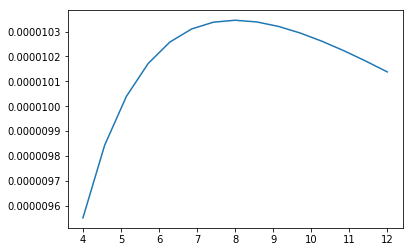

Best smoothing value is 8.000


In [6]:
def cv_great_wall(X, bws, k_fold = 10, kernel = "gaussian"):
    """ Use cross validation to determine the best 
    smoothing parameter
    
    Input:
    X      = The data
    bws    = Array of smoothing parameters to try
    k_fold = Number of folds to use
    kernel = The prevered kernel to produce the kernelDensity
    """
    
    N = len(X)
    lh = np.zeros_like(bws) #likelihood
    
    for i, bw in enumerate(bws):
        print i
        lnP = 0.0
        # Split train and test data
        kf = KFold(k_fold)
        
        for train, test in kf.split(X):
            Xtrain, Xtest = X[train,:], X[test, :]
            kde = KernelDensity(bw, kernel=kernel).fit(Xtrain)
            # Evaluate the log density on Xtest using KDE fitted on Xtrain
            logdens = kde.score(Xtest)
            lnP += logdens
            
        # The average likelihood of bw
        lh[i] = lnP/N
    
    return lh

# Smoothings parameters to try with cross-validation value
bws = np.linspace(4, 12, 15)
print bws
cv = cv_great_wall(X, bws)

# Plot the results to find best smoothing value
plt.plot(bws, np.exp(cv))
plt.show()

print "Best smoothing value is {0:.3f}".format(bws[np.argmax(cv)])
   

In [7]:
# Narrow the bws to get the best values
bws_best = bws[np.argmax(cv)]
bws = np.linspace(bws_best-2, bws_best+2, 10)
cv2 = cv_great_wall(X, bws)

print "New found best smoothing value = {0:.3f}".format(bws[np.argmax(cv2)])
   

0
1
2
3
4


KeyboardInterrupt: 

In [9]:
import scipy.interpolate as interpolate

In [27]:
bws = np.linspace(4, 12, 15)
bws_new = np.linspace(7, 9, 500)
f = interpolate.interp1d(bws, cv)

print bws_new[np.argmax(f(bws_new))]


8.00200400802


array([  1.03170692e-05,   1.03172595e-05,   1.03174499e-05,
         1.03176402e-05,   1.03178305e-05,   1.03180209e-05,
         1.03182112e-05,   1.03184015e-05,   1.03185919e-05,
         1.03187822e-05,   1.03189726e-05,   1.03191629e-05,
         1.03193533e-05,   1.03195437e-05,   1.03197340e-05,
         1.03199244e-05,   1.03201148e-05,   1.03203052e-05,
         1.03204955e-05,   1.03206859e-05,   1.03208763e-05,
         1.03210667e-05,   1.03212571e-05,   1.03214475e-05,
         1.03216379e-05,   1.03218283e-05,   1.03220187e-05,
         1.03222091e-05,   1.03223996e-05,   1.03225900e-05,
         1.03227804e-05,   1.03229708e-05,   1.03231613e-05,
         1.03233517e-05,   1.03235421e-05,   1.03237326e-05,
         1.03239230e-05,   1.03241135e-05,   1.03243039e-05,
         1.03244944e-05,   1.03246848e-05,   1.03248753e-05,
         1.03250658e-05,   1.03252562e-05,   1.03254467e-05,
         1.03256372e-05,   1.03258277e-05,   1.03260181e-05,
         1.03262086e-05,

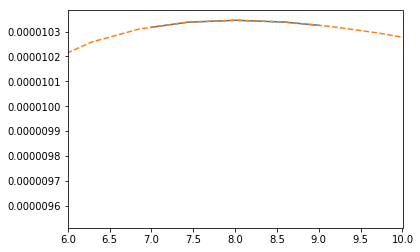

In [35]:
plt.plot(bws_new, np.exp(f(bws_new)))
plt.plot(bws, np.exp(cv),ls='--')
#plt.yscale('log')
plt.xlim(6, 10)
plt.show()